# Tutorial 3 - Trace Elements
Simon Matthews (University of Iceland) and Kevin Wong (University of Leeds)

## Introduction

pyMelt contains a chemistry module for calculating the trace element composition of melts. There are a number of inbuilt chemical methods:
- Batch melting
- Continuous melting, which can be used to calculate either instantaneous or accumulated melts
- Invmel, following McKenzie & O'Nions (1991), incorporates the effect of aluminous phase transitions and phase exhaustion
Currently the methods all use constant partition coefficients, but soon using pressure and temperature dependent partition coeffients will be an option.

The module is designed to allow maximum customisation of the calculations, but using the default options is very straightforward. Invmel is used for most elements by default, with the exception of the most incompatible elements, which are modelled assuming continuous melting with 0.5% porosity. See the documentation for more information about the partition coefficients used.

First we must import the required modules as before:

In [1]:
import pyMelt as m
import matplotlib.pyplot as plt
import numpy as np

## Making MORB from a homogeneous mantle
In the first example we will predict the composition of a spreading centre basalt using the default options.

First we must create a `Mantle` object and perform adiabatic melting, as before:

In [5]:
lz = m.lithologies.matthews.klb1()
mantle = m.Mantle([lz], [1.0], ['lz'])
column = mantle.AdiabaticMelt(1350.0)

We must now add chemistry to these melts. The default options are designed for melting depleted mantle, so we don't need to set up or pass any additional arguments:

In [6]:
column.calculate_chemistry()

Lithology composition is set to the depleted mantle of Workman & Hart (2005).


Notice that pyMelt told us it was setting the composition to the depleted mantle. See below for how to adjust this. At this point we can already inspect some of the instantaneous results:

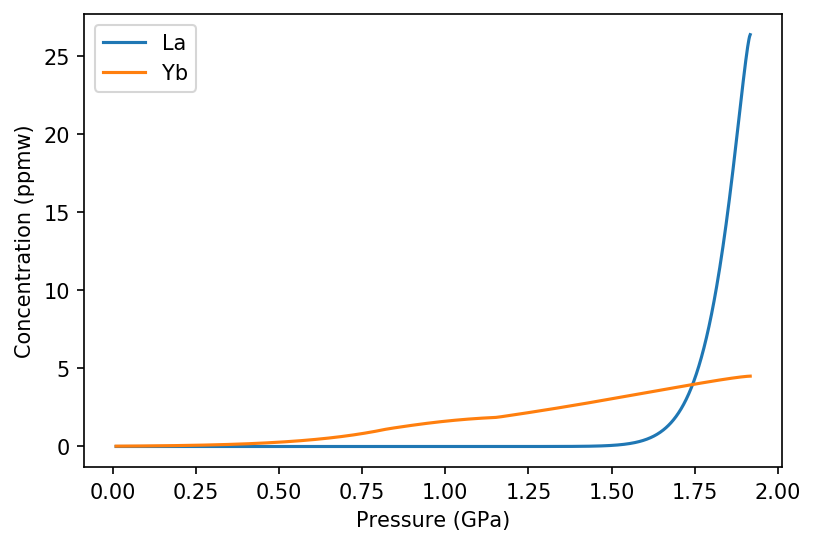

In [27]:
f, a = plt.subplots(dpi=150)
a.plot(column.P, column.lithologies['lz']['La'], label='La')
a.plot(column.P, column.lithologies['lz']['Yb'], label='Yb')

a.set_ylabel('Concentration (ppmw)')
a.set_xlabel('Pressure (GPa)')
a.legend()
plt.show()

Notice how Yb behaves more compatibly than La, persisting for much longer in melts. The subtle change in gradient in the Yb line occurs during the spinel to plagioclase transition.

When the `SpreadingCentre` `GeoSetting` class is created pyMelt automatically calculates the crustal thickness based on a triangular melting region with passive upwelling (as shown in Tutorial 1). If the `MeltingColumn` class contains chemistry, creating the `GeoSetting` class also applies the appropriate homogenisation calculation. For a spreading centre this is homogenisation with a triangular weighting.

In [10]:
morb = m.geosettings.SpreadingCentre(column)

We can view the raw homogenised trace element concentrations:

In [11]:
morb.chemistry

Rb       0.398666
Ba       4.486221
Th       0.064516
U        0.026008
Nb       1.197164
Ta       0.077386
La       1.513461
Ce       4.254706
Pb       0.143062
Pr       0.806788
Nd       4.241966
Sr      59.352718
Zr      37.873585
Hf       1.072105
Sm       1.645691
Eu       0.653027
Ti    4314.469826
Gd       2.431075
Tb       0.463382
Dy       3.364543
Ho       0.764368
Y       20.781282
Er       2.178212
Yb       2.179588
Lu       0.333920
dtype: float64

But to really make sense of the results it is convenient to make a spider diagram, for which the `GeoSetting` classes have a built in method. There are many ways to customise the plot, most importantly the reference values used for normalisation. The default normalisation is the primitive mantle of Palme & O'Neill (2013).

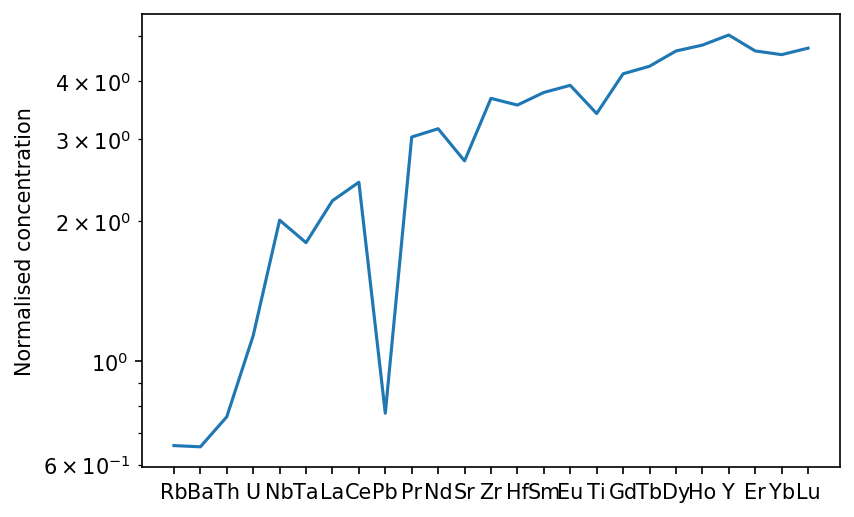

In [13]:
f,a = morb.plot_spider()
plt.show()

If we wanted to see just the rare earth elements, we can specify this. We can also normalise to chondrite, and show the range of instantaneous melts:

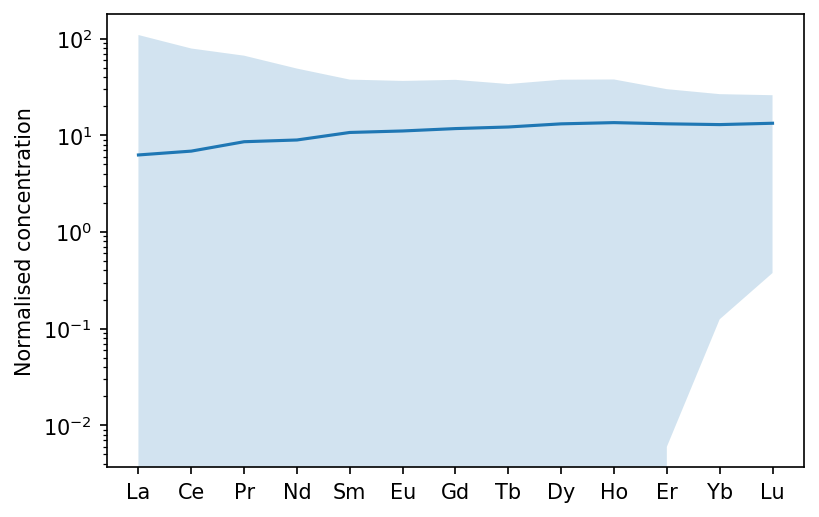

In [18]:
f,a = morb.plot_spider(element_order=['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb','Lu'], 
                       normalisation='CI', plot_instantaneous=True)
plt.show()

Finally, we can see what the effect of some crystal fractionation would be on the composition. This time I will normalise to depleted mantle, to remove the Pb anomaly.

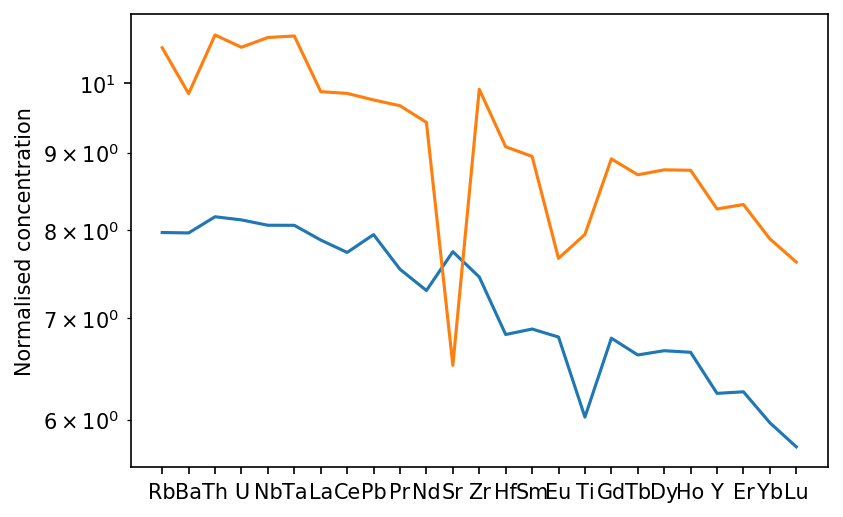

In [25]:
f,a = morb.plot_spider(normalisation='DM', crystal_fraction={'olv':0.05, 'plg':0.2})
plt.show()

Crystallising olivine and plagioclase has enriched the melt in trace elements, with the exception of Sr, since it is very compatible in plagioclase. Eu also shows a negative anomaly owing also to its relative compatibility in plagioclase. The crystallisation calculation can also be used independently of plotting. In fact the plotting method just calls the `GeoSetting.crystallisation_chemistry()`  See the documentation for `GeoSetting.crystallisation_chemistry()` for information about customising the crystallisation calculation.